# Robustness
In this example we analyze how robust feature selection with BINN is. All feature selection methods are data-greedy, meaning that we need many samples to generate robust estimations of feature importance. One way to analyze this is to train and explain several models, and compare their feature importances.

In [24]:
from binn import Network, BINN
import pandas as pd

input_data = pd.read_csv("../data/test_qm.csv")
translation = pd.read_csv("../data/translation.tsv", sep="\t")
pathways = pd.read_csv("../data/pathways.tsv", sep="\t")

network = Network(
    input_data=input_data,
    pathways=pathways,
    mapping=translation,
    source_column="child",
    target_column="parent",
)

                
binn = BINN(
    network=network,
    n_layers=4,
    dropout=0.2,
    validate=False,
    residual=False,
    device="cpu",
    learning_rate =0.001
)



BINN is on the device: cpu


In [25]:
from util_for_examples import fit_data_matrix_to_network_input, generate_data
import torch

design_matrix = pd.read_csv("../data/design_matrix.tsv", sep="\t")

protein_matrix = fit_data_matrix_to_network_input(input_data, features=network.inputs)

X, y = generate_data(protein_matrix, design_matrix=design_matrix)
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32, device=binn.device),
    torch.tensor(y, dtype=torch.int16, device=binn.device),
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [26]:
from binn.explainer import BINNExplainer

explainer = BINNExplainer(binn)


## Explain average
In ```exlpainer.explain_average()``` we can train the n models and explain them separately. Their resulting feature importances are concatenated to the outputted ```ìmportance_df```. 

In [35]:
test_data = torch.Tensor(X)
background_data = torch.Tensor(X)

n_iterations = 10
n_epochs = 30

importance_df = explainer.explain_average(test_data, background_data, n_iterations, n_epochs, dataloader, fast_train=True)
importance_df.head()

Iteration 0
Final epoch: Average Accuracy 0.98, Average Loss: 0.10
Iteration 1
Final epoch: Average Accuracy 0.98, Average Loss: 0.08
Iteration 2
Final epoch: Average Accuracy 0.93, Average Loss: 0.16
Iteration 3
Final epoch: Average Accuracy 0.97, Average Loss: 0.11
Iteration 4
Final epoch: Average Accuracy 0.96, Average Loss: 0.10
Iteration 5
Final epoch: Average Accuracy 1.00, Average Loss: 0.06
Iteration 6
Final epoch: Average Accuracy 0.95, Average Loss: 0.12
Iteration 7
Final epoch: Average Accuracy 0.98, Average Loss: 0.08
Iteration 8
Final epoch: Average Accuracy 0.97, Average Loss: 0.08
Iteration 9
Final epoch: Average Accuracy 0.98, Average Loss: 0.09


,source,target,source name,target name,type,source layer,target layer,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_mean,values_std,value
0,1,497,A0M8Q6,R-HSA-166663,0,0,1,0.082424,0.067336,0.121985,0.014082,0.136884,0.072354,0.098352,0.096156,0.085417,0.052298,0.082729,0.032998,0.082729
1,1,497,A0M8Q6,R-HSA-166663,1,0,1,0.041309,0.044959,0.034864,0.098221,0.032610,0.055007,0.066917,0.035010,0.048155,0.129446,0.058650,0.030101,0.058650
2,1,954,A0M8Q6,R-HSA-198933,0,0,1,0.082424,0.067336,0.121985,0.014082,0.136884,0.072354,0.098352,0.096156,0.085417,0.052298,0.082729,0.032998,0.082729
3,1,954,A0M8Q6,R-HSA-198933,1,0,1,0.041309,0.044959,0.034864,0.098221,0.032610,0.055007,0.066917,0.035010,0.048155,0.129446,0.058650,0.030101,0.058650
4,1,539,A0M8Q6,R-HSA-2029481,0,0,1,0.082424,0.067336,0.121985,0.014082,0.136884,0.072354,0.098352,0.096156,0.085417,0.052298,0.082729,0.032998,0.082729


In [28]:
importance_df["copy"] = importance_df.apply(lambda x: True if x["source name"] == x["target name"] else False, axis=1)
importance_df = importance_df[importance_df["copy"] == False]
importance_df

,source,target,source name,target name,type,source layer,target layer,value_0,value_1,value_2,...,value_4,value_5,value_6,value_7,value_8,value_9,value_mean,values_std,value,copy
0,1,497,A0M8Q6,R-HSA-166663,0,0,1,0.057292,0.031902,0.072215,...,0.026327,0.051485,0.049959,0.083155,0.038823,0.071860,0.056468,0.019296,0.056468,False
1,1,497,A0M8Q6,R-HSA-166663,1,0,1,0.033034,0.047299,0.129302,...,0.073976,0.053785,0.027834,0.039571,0.049074,0.025036,0.051177,0.029457,0.051177,False
2,1,954,A0M8Q6,R-HSA-198933,0,0,1,0.057292,0.031902,0.072215,...,0.026327,0.051485,0.049959,0.083155,0.038823,0.071860,0.056468,0.019296,0.056468,False
3,1,954,A0M8Q6,R-HSA-198933,1,0,1,0.033034,0.047299,0.129302,...,0.073976,0.053785,0.027834,0.039571,0.049074,0.025036,0.051177,0.029457,0.051177,False
4,1,539,A0M8Q6,R-HSA-2029481,0,0,1,0.057292,0.031902,0.072215,...,0.026327,0.051485,0.049959,0.083155,0.038823,0.071860,0.056468,0.019296,0.056468,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6901,1319,0,R-HSA-9612973,root,1,4,5,0.168732,0.119193,0.382712,...,0.221143,0.306118,0.133829,0.069731,0.021349,0.306654,0.180958,0.113130,0.180958,False
6902,1320,0,R-HSA-9709957,root,0,4,5,0.282160,0.310405,0.046911,...,0.056053,0.235610,0.185094,0.237833,0.098621,0.226858,0.188058,0.086944,0.188058,False
6903,1320,0,R-HSA-9709957,root,1,4,5,0.000856,0.136307,0.297282,...,0.093029,0.040322,0.169211,0.004483,0.087137,0.031249,0.086141,0.089588,0.086141,False
6904,1321,0,R-HSA-9748784,root,0,4,5,0.133147,0.150910,0.033321,...,0.005379,0.094346,0.064461,0.094471,0.003258,0.029948,0.064763,0.049052,0.064763,False


In [29]:
importance_df_copy = importance_df.groupby(["source name", "source layer", "target layer"], as_index=False).mean(numeric_only=True)
mean_ranks = []
std_ranks = []
source_layer = []
sources = []
for layer in range(binn.n_layers):
    layer_df = importance_df_copy[importance_df_copy["source layer"] == layer].copy()
    for i in range(n_iterations):
        layer_df.sort_values(f"value_{i}", ascending=False, inplace=True)
        layer_df[f"rank_{i}"] = range(len(layer_df.index))
    rank_cols = [c for c in layer_df.columns if c.startswith("rank")]
    mean_ranks += (layer_df[rank_cols].mean(axis=1)/ len(layer_df.index)).tolist()
    sources += layer_df["source name"].tolist()
    std_ranks  += (layer_df[rank_cols].std(axis=1)/ len(layer_df.index)).tolist()
    source_layer += layer_df["source layer"].tolist()
plot_df = pd.DataFrame({"mean":mean_ranks, "std":std_ranks, "source layer":source_layer, "source":sources})

In [30]:
plot_df.sort_values("mean").head(20)

,mean,std,source layer,source
0,0.000223,0.000704,0,P04114
449,0.003257,0.005093,1,R-HSA-140534
450,0.004886,0.008986,1,R-HSA-975634
2,0.006682,0.005035,0,P02647
1,0.007572,0.009344,0,P08571
756,0.008108,0.015492,2,R-HSA-5357769
10,0.017372,0.013641,0,Q9UBR2
6,0.020713,0.014243,0,P04908
5,0.021604,0.010812,0,P68871
22,0.022049,0.013907,0,P02452


If we now plot the mean and standard deviation of the rank, we see that highly important features generally have a low standard deviation. We can therefore be the most certain about the most important features.

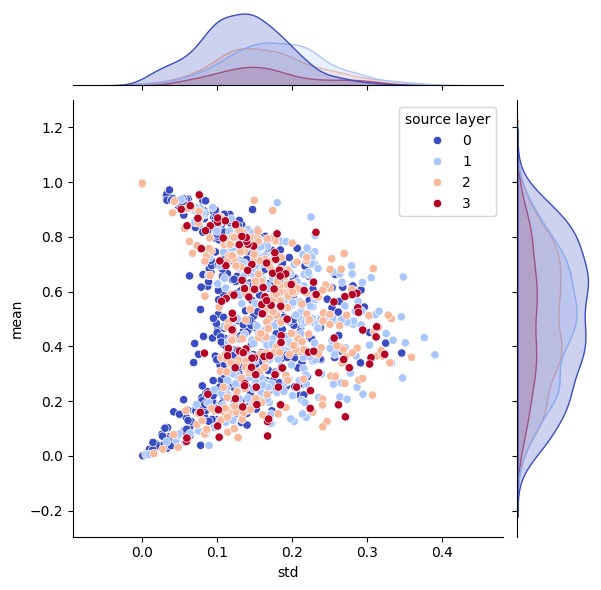

In [31]:
import seaborn as sns


sns.jointplot(plot_df, y="mean", x="std", hue="source layer", palette="coolwarm")



In [32]:
from binn import ImportanceNetwork

IG = ImportanceNetwork(importance_df, norm_method="fan")


In [33]:
IG.plot_complete_sankey(
    multiclass=False, savename="img/complete_sankey.png", node_cmap="Accent_r", edge_cmap="Accent_r"
)

In [34]:
query_node = "R-HSA-597592"

IG.plot_subgraph_sankey(
    query_node, upstream=True, savename="img/subgraph_sankey.png", cmap="coolwarm"
)